In [1]:
import pymysql,sys,json
import seaborn as sns
import traceback
import cPickle as pickle
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.decomposition import PCA
import sklearn

In [2]:
sns.set_style('white')
sns.despine()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
conn = pymysql.connect(host='localhost',user='root',passwd='pulsetini', db='nairaland',charset='utf8')
cur = conn.cursor()
cur2 = conn.cursor()

In [4]:
topicDf=pd.read_sql_query('select count(*),topic from post_topics group by topic',conn)

In [14]:
topics=topicDf.topic.values

In [6]:
topicCounter=collections.Counter()
for row in topicDf.iterrows():
#    print row
    topicCounter[row[1][1]]=row[1][0]

In [7]:
sortedMostCommon=topicCounter.most_common(20)
sortedMostCommon.reverse()

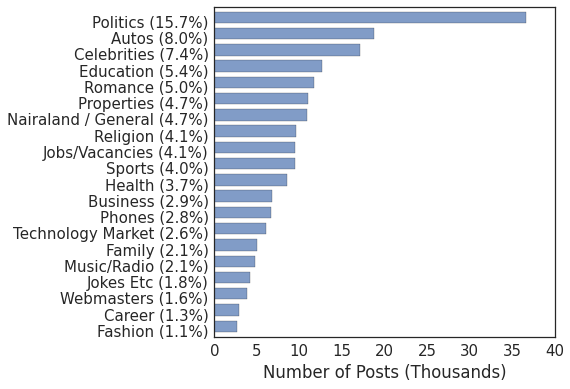

In [16]:
total=float(sum(topicCounter.values()))
plt.barh(range(len(sortedMostCommon)),[c[1]/1000.0 for c in sortedMostCommon],height=0.7,alpha=0.7)
plt.ylim(-0.3,len(sortedMostCommon))
plt.yticks(range(len(sortedMostCommon)),[c[0]+' (%2.1f%%)' % (100*(c[1]/total)) for c in sortedMostCommon])
plt.xlabel('Number of Posts (Thousands)')
plt.tight_layout()
plt.savefig('post_topic_dist.png',dpi=250)

###### SVD of Topics

In [12]:
%time topicDf=pd.read_sql_query('select user,topic,count(*) from posts3 group by user,topic',conn)

CPU times: user 83.6 ms, sys: 1.01 ms, total: 84.6 ms
Wall time: 27min 3s


In [5]:
%time topicDf2=pd.read_sql_query('select user,topic,count(*) from posts_2013 group by user,topic',conn)

CPU times: user 2.64 s, sys: 36 ms, total: 2.67 s
Wall time: 6.24 s


In [ ]:
%time topicDf=pd.read_sql_query('select posts3.user,posts3.topic,users.gender,count(*) from `posts3` inner join `users` on posts3.user = users.userName group by topic',conn)

In [ ]:
topicDf.shape

In [4]:
%time userGenderDf=pd.read_sql_query('select userName,gender from users',conn)

CPU times: user 2.79 s, sys: 31 ms, total: 2.82 s
Wall time: 2.83 s


In [5]:
%time userPostsDf=pd.read_sql_query('select userName,postsInDb from users',conn)

CPU times: user 3.01 s, sys: 31.9 ms, total: 3.04 s
Wall time: 3.05 s


In [6]:
genderDict=dict([(r[1].userName,r[1].gender) for r in userGenderDf.iterrows()])

In [7]:
postsDict=dict([(r[1].userName,r[1].postsInDb) for r in userPostsDf.iterrows()])

In [8]:
def getGender(u):
    try:
        return genderDict[u]
    except:
        return ''

In [9]:
def getPosts(u):
    try:
        return postsDict[u]
    except:
        return 0

In [13]:
topicDf['gender']=topicDf['user'].apply(getGender)
topicDf['posts']=topicDf['user'].apply(getPosts)

In [45]:
male=pd.pivot_table(topicDf[(topicDf['gender']==' m')],index=['user'],columns=['topic'],fill_value=0)
female=pd.pivot_table(topicDf[(topicDf['gender']==' f')],index=['user'],columns=['topic'],fill_value=0)
unknown=pd.pivot_table(topicDf[(topicDf['gender']=='')],index=['user'],columns=['topic'],fill_value=0)

###### Pivot Results in a Hierarchical MultiIndex

In [129]:
nCutoff=0
male=pd.pivot_table(topicDf[(topicDf['gender']==' m')&(topicDf['posts']>nCutoff)],index='user',columns=['topic'],fill_value=0)
female=pd.pivot_table(topicDf[(topicDf['gender']==' f')&(topicDf['posts']>nCutoff)],index=['user'],columns=['topic'],fill_value=0)
unknown=pd.pivot_table(topicDf[(topicDf['gender']=='')&(topicDf['posts']>nCutoff)],index=['user'],columns=['topic'],fill_value=0)

###### Pull Out Values

In [130]:
male=male['count(*)']
female=female['count(*)']
unknown=unknown['count(*)']

In [131]:
print len(male.columns)
print len(female.columns)
print len(unknown.columns)

62
59
64


###### Some Groups don't make any Posts in Some Topics: So Fill Them in

In [132]:
for topic in topics:
    if not topic in male.columns:
        male[topic]=0
    if not topic in female.columns:
        female[topic]=0
    if not topic in unknown.columns:
        unknown[topic]=0

In [133]:
unknownMatrix=unknown.as_matrix()
maleMatrix=male.as_matrix()
femaleMatrix=female.as_matrix()

In [134]:
binarizer=sklearn.preprocessing.Binarizer().fit(maleMatrix)
maleMatrixBinary=binarizer.transform(maleMatrix)
femaleMatrixBinary=binarizer.transform(femaleMatrix)
unknownMatrixBinary=binarizer.transform(unknownMatrix)

In [135]:
print maleMatrixBinary.shape
print femaleMatrixBinary.shape
print unknownMatrixBinary.shape

(10006, 64)
(1689, 64)
(13816, 64)


###### Male Users

In [136]:
binary=False

In [137]:
malePca=PCA(n_components=2,whiten=True)
if binary:
    maleRes=malePca.fit(maleMatrixBinary)
else:
    maleRes=malePca.fit(maleMatrix)
maleColumns=male.columns
topicWeights=collections.Counter()
print maleRes.noise_variance_
print malePca.explained_variance_
print '----------------'

for nComp in [0,1]:

    for n,weight in enumerate(maleRes.components_[nComp,:]):
        topicWeights[male.columns[n]]=weight

    for t in topicWeights.most_common(10):
        print t[0],'%.4f' % t[1]
    print '------------'

0.936393853755
[ 25.31914299  21.47000017]
----------------
Politics 0.1716
Celebrities 0.0878
Nairaland / General 0.0258
Romance 0.0210
Religion 0.0191
Health 0.0145
Sports 0.0142
Education 0.0136
Family 0.0091
Celebrity Crimes 0.0085
------------
Autos 0.2157
Adverts 0.0032
Politics 0.0032
Properties 0.0031
Car Talk 0.0022
Technology Market 0.0015
Health 0.0012
Business To Business 0.0004
Agriculture 0.0003
Religion 0.0003
------------


###### Female Users

In [138]:
femalePca=PCA(n_components=2,whiten=True)
if binary:
    femaleRes=femalePca.fit(femaleMatrixBinary)
else:
    femaleRes=femalePca.fit(femaleMatrix)

femaleColumns=female.columns
topicWeights=collections.Counter()
print femaleRes.noise_variance_

for nComp in [0,1]:

    for n,weight in enumerate(femaleRes.components_[nComp,:]):
        topicWeights[female.columns[n]]=weight

    for t in topicWeights.most_common(10):
        print t[0],'%.4f' % t[1]
    print '------------'

0.401364835956
Jobs/Vacancies 0.0032
Technology Market 0.0003
Properties 0.0003
Literature 0.0002
Fashion/Clothing Market 0.0002
Adverts 0.0002
Business To Business 0.0002
Career 0.0002
up Zone 0.0001
Phone/Internet Market 0.0001
------------
Romance 0.0081
Politics 0.0044
Nairaland / General 0.0032
Autos 0.0030
Family 0.0022
Health 0.0018
Religion 0.0011
Sports 0.0009
Properties 0.0008
Jokes Etc 0.0007
------------


###### Unknown Users

In [139]:
nCompChosen=2
unknownPca=PCA(n_components=nCompChosen,whiten=True)
if binary:
    unknownRes=unknownPca.fit(unknownMatrixBinary)
else:
    unknownRes=pca.fit(unknownMatrix)
unknownColumns=unknown.columns
topicWeights=collections.Counter()

for nComp in range(nCompChosen):

    for n,weight in enumerate(unknownRes.components_[nComp,:]):
        topicWeights[unknown.columns[n]]=weight

    for t in topicWeights.most_common(10):
        print t[0],'%.4f' % t[1]
    print '------------'

Politics 0.0044
Celebrities 0.0016
Education 0.0010
Sports 0.0007
Nairaland / General 0.0006
Health 0.0005
Romance 0.0005
Jobs/Vacancies 0.0005
Religion 0.0004
Music/Radio 0.0003
------------
Properties 0.0316
Technology Market 0.0004
Adverts 0.0002
Business To Business 0.0002
Programming 0.0002
Certification And Training Adverts 0.0001
Fashion/Clothing Market 0.0001
Phone/Internet Market 0.0001
up Zone 0.0001
Gaming 0.0000
------------


###### Try to Project Unknown Onto M/F PCs

In [140]:
proj=malePca.transform(unknownMatrixBinary)

In [141]:
proj[:,0].shape

(13816,)

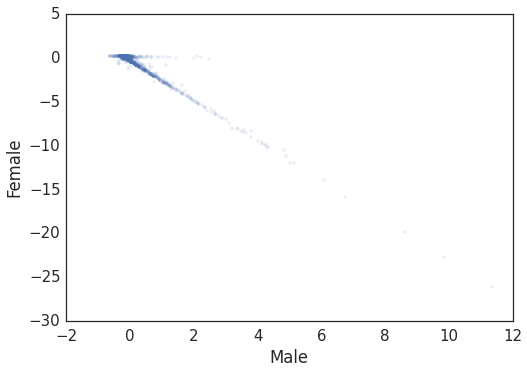

In [142]:
if binary:
    plt.plot(malePca.transform(unknownMatrixBinary)[:,0],femalePca.transform(unknownMatrixBinary)[:,0],'.',alpha=0.1)
else:
    plt.plot(malePca.transform(unknownMatrix)[:,0],femalePca.transform(unknownMatrix)[:,0],'.',alpha=0.1)
plt.xlabel('Male')
plt.ylabel('Female')

In [104]:
proj=pca.transform(unknownMatrixBinary)

In [105]:
proj[:,0]

array([-0.03201791,  0.57925319,  0.42357743, ..., -0.52177696,
       -0.68916968, -0.03650956])

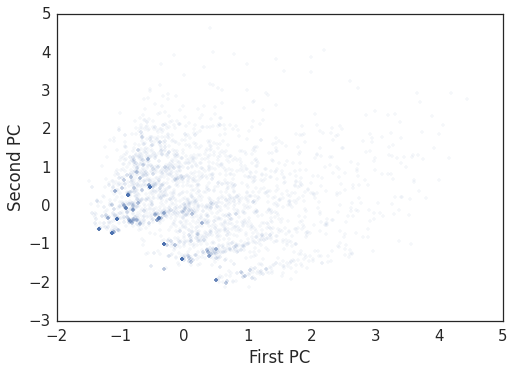

In [106]:
plt.plot(proj[:,0],proj[:,1],'.',alpha=0.05)
plt.xlabel('First PC')
plt.ylabel('Second PC')

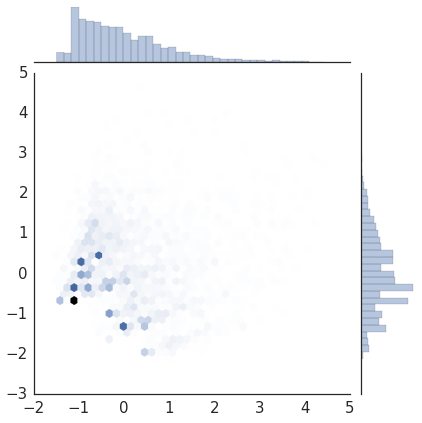

In [107]:
sns.jointplot(proj[:,0],proj[:,1],stat_func=None,kind='hex')

In [188]:
import sklearn.cluster

In [195]:
kmeans=sklearn.cluster.KMeans(n_clusters=3)

In [197]:
res=kmeans.fit(proj)

In [203]:
res.cluster_centers_

array([[ 0.60770111, -0.89871375],
       [-0.79927376,  0.03679196],
       [ 0.63306517,  1.34388869]])

In [200]:
res.predict(proj)

array([0, 0, 0, ..., 2, 1, 1], dtype=int32)

###### Make a Network

In [208]:
adjacency=np.zeros(shape=(len(topics),len(topics)))

In [212]:
test=np.array([0,1])

In [ ]:
for row in maleMatrixBinary.iter

###### Plot Gender Distribution of Topics

In [148]:
male.shape

(10006, 64)

In [152]:
topicGenderCounter=collections.Counter()
for topic in topics:
#    print male[topic].sum()/float(male.shape[0]),female[topic].sum()/float(female.shape[0]),unknown[topic].sum()/float(unknown.shape[0])
    topicGenderCounter[topic]=male[topic].sum()/float(male.shape[0])-female[topic].sum()/float(female.shape[0])

<Container object of 64 artists>

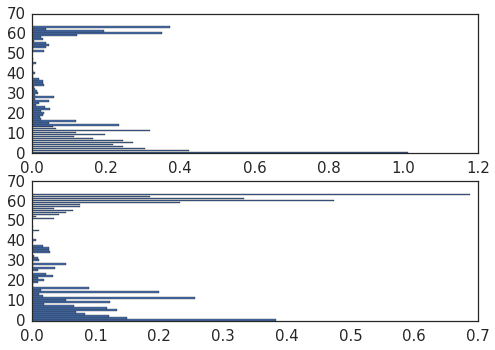

In [174]:
plt.subplot(2, 1, 1)
plt.barh(range(len(topics)),[male[topic].sum()/float(male.shape[0]) for topic,count in topicGenderCounter.most_common()])
plt.subplot(2, 1, 2)
plt.barh(range(len(topics)),[female[topic].sum()/float(female.shape[0]) for topic,count in topicGenderCounter.most_common()])

###Look at thread lengths by topic

In [4]:
%time commentsByTopic=pd.read_sql_query('select topic,nComments from posts_2013;',conn)

CPU times: user 5.26 s, sys: 84.4 ms, total: 5.35 s
Wall time: 5.36 s


In [34]:
topicStats=pd.DataFrame(columns=['topic','mean','max','number'])
for n,g in enumerate(commentsByTopic.groupby('topic')):
    vals=np.array(g[1].nComments.values)
#    print g[0]+':\t','%d' % vals.mean(),vals.max(),len(vals)
    topicStats.loc[n]=[g[0],vals.mean(),vals.max(),len(vals)]
#    sys.exit(1)

In [35]:
topicStats.sort(columns='mean',ascending=False)[0:10]

,topic,mean,max,number
39,Nairaland Ads,379.000000,601,4
24,Forum Games,122.178295,12337,258
17,"European Football (EPL, UEFA, La Liga)",47.141509,1700,954
19,Family,30.549003,10370,3561
49,Romance,29.858206,6186,8329
48,Religion,26.237765,40290,9808
56,Travel,25.615563,15829,1722
42,Phones,24.262004,12464,6019
13,Culture,23.183579,2033,1291
54,TV/Movies,22.545546,5207,1998


In [36]:
topicStats.sort(columns='number',ascending=False)[0:10]

,topic,mean,max,number
44,Politics,18.779545,3830,26341
3,Autos,9.804171,2461,22678
8,Celebrities,8.620427,602,15989
46,Properties,3.994631,2698,15645
48,Religion,26.237765,40290,9808
55,Technology Market,9.589532,13176,9572
14,Education,17.380555,33046,9473
31,Jobs/Vacancies,8.000647,4912,9280
49,Romance,29.858206,6186,8329
38,Nairaland / General,11.973331,6999,7162


In [37]:
topicStats.sort(columns='max',ascending=False)[0:10]

,topic,mean,max,number
4,Business,14.606791,41678,6597
48,Religion,26.237765,40290,9808
14,Education,17.380555,33046,9473
56,Travel,25.615563,15829,1722
55,Technology Market,9.589532,13176,9572
42,Phones,24.262004,12464,6019
24,Forum Games,122.178295,12337,258
19,Family,30.549003,10370,3561
38,Nairaland / General,11.973331,6999,7162
41,Phone/Internet Market,9.441133,6685,2684


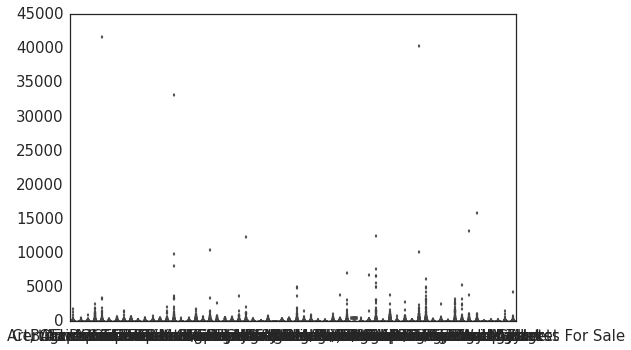

In [14]:
sns.boxplot([g[1].nComments.values for g in commentsByTopic.groupby('topic')],names=[g[0] for g in commentsByTopic.groupby('topic')])

In [ ]:
for